In [108]:
# make n folders in a specific path
import os

def make_folders(n, path = '/Users/nickaloyd/Library/Mobile Documents/com~apple~CloudDocs/Purdue/Deep Learning/Car Kaggle Comp/data'):
    for i in range(1, n+1):
        os.makedirs(os.path.join(path, str(i)), exist_ok=True)

make_folders(196)

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def load_image(image_num, dataset_split = 'train'):
    _ = '../Car Kaggle Comp/car-classification-with-adversarial-defense/cars_training_image/cars_train/'
    if dataset_split == 'test': _ = '../Car Kaggle Comp/car-classification-with-adversarial-defense/cars_testing_image/car_test_with_adv_attack/'
    return cv2.imread(_ + image_num)

def write_image(img, class_num, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/data/{class_num}/{image_num}', img)


# pre processing functions
def flip(img):
    return cv2.flip(img, 1)

def add_noise(img, sigma=0.03, mean=0):
    row, col= img.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    gauss = gauss.reshape(row, col)
    noisy = img + gauss
    return noisy

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def grayscale(img):
    img = np.array(img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [ ]:
import pandas as pd 

test_csv = pd.read_csv('../Car Kaggle Comp/car-classification-with-adversarial-defense/car_dataset_test_boundingBox_image_number.csv')
train_csv = pd.read_csv('../Car Kaggle Comp/car-classification-with-adversarial-defense/car_boundingBox_class_and_image_number.csv')

def get_csv(dataset_split = 'train'):
    if dataset_split == 'test': return test_csv
    return train_csv

0.0
0.12278978388998035
0.2455795677799607
0.36836935166994106
0.4911591355599214
0.6139489194499018
0.7367387033398821
0.8595284872298625
0.9823182711198428


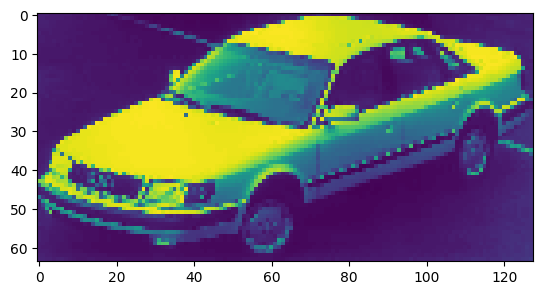

In [ ]:
def write_test_image(img, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/test_data/{image_num}', img)

def write_test_images(dataset_split = 'test', resolution = (128, 64)):
    for i, row in enumerate(test_csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(test_csv))
        
        row = row[1]
        
        image_num = row['image']
        if dataset_split == 'train': class_num = row['Class']

        img = load_image(row['image'], dataset_split)

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        img = grayscale(img)
        
        plt.imshow(img)
        write_test_image(img, image_num)

def write_train_image(img, class_num, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/data/{class_num}/{image_num}', img)

def write_train_images(dataset_split = 'train', resolution = (128, 64)):
    for i, row in enumerate(train_csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(train_csv))
        
        row = row[1]
        
        class_num = row['Class']
        image_num = row['image']

        img = load_image(row['image'], 'train')

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        img = grayscale(img)
        
        plt.imshow(img)
        write_image(img, class_num, image_num)


def write_images(dataset_split = 'train', resolution = (128, 64)):
    csv = get_csv(dataset_split)

    for i, row in enumerate(csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(csv))
        
        row = row[1]

        if dataset_split == 'train': class_num = row['Class']

        image_num = row['image']

        img = load_image(row['image'], dataset_split)

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        img = grayscale(img)
        
        plt.imshow(img)
        write_image(img, class_num, image_num)

#write_images('train')
#write_images('test')

In [ ]:
def write_test_image(img, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/test_data/{image_num}', img)

def write_test_images(dataset_split = 'test', resolution = (128, 64)):
    for i, row in enumerate(test_csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(test_csv))
        
        row = row[1]
        
        image_num = row['image']
        if dataset_split == 'train': class_num = row['Class']

        img = load_image(row['image'], dataset_split)

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        img = grayscale(img)
        
        plt.imshow(img)
        write_test_image(img, image_num)

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader



# Define the path to your local data folder
data_dir = '../Car Kaggle Comp/data'
test_data_dir = '../Car Kaggle Comp/test_data'



# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split into training and validation sets (optional)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Training set: {len(train_loader.dataset)} samples")
print(f"Validation set: {len(val_loader.dataset)} samples")

Training set: 6515 samples
Validation set: 1629 samples


In [113]:
# Load the dataset (the original dataset, not a subset)
#full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Get the number of classes
num_classes = len(full_dataset.classes)

# Create DataLoader for training set
train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)

# 2. Define the CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the size of the feature map after conv and pooling
        self._to_linear = None
        self.convs(torch.randn(1, 1, 128, 64))  # Pass a dummy input to calculate the output size

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)  # Adjust based on computed size
        self.fc2 = nn.Linear(512, num_classes)  # Output layer size matches the number of classes

    def convs(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first conv + relu + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second conv + relu + pooling
        if self._to_linear is None:
            self._to_linear = x.numel()  # Save the number of elements for the fully connected layer
        return x

    def forward(self, x):
        x = self.convs(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the tensor correctly
        x = torch.relu(self.fc1(x))  # Apply first fully connected layer
        x = self.fc2(x)  # Apply second fully connected layer (output layer)
        return x

# 3. Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)  # Pass num_classes to the model

criterion = nn.CrossEntropyLoss()  # Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Train Function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagate
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print loss and accuracy per epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# 5. Start Training
train_model(model, train_loader, criterion, optimizer, device, epochs=10)

Epoch [1/10], Loss: 5.2982, Accuracy: 0.0039
Epoch [2/10], Loss: 5.2573, Accuracy: 0.0102
Epoch [3/10], Loss: 5.1109, Accuracy: 0.0206
Epoch [4/10], Loss: 4.8139, Accuracy: 0.0467
Epoch [5/10], Loss: 4.0325, Accuracy: 0.1340
Epoch [6/10], Loss: 2.6434, Accuracy: 0.3714
Epoch [7/10], Loss: 1.1545, Accuracy: 0.7043
Epoch [8/10], Loss: 0.3032, Accuracy: 0.9279
Epoch [9/10], Loss: 0.0872, Accuracy: 0.9882
Epoch [10/10], Loss: 0.0417, Accuracy: 0.9953


In [114]:
def write_test_image(img, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/test_data/{image_num}', img)

def write_test_images(dataset_split = 'test', resolution = (128, 64)):
    for i, row in enumerate(test_csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(test_csv))
        
        row = row[1]
        
        image_num = row['image']
        if dataset_split == 'train': class_num = row['Class']

        img = load_image(row['image'], dataset_split)

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        img = grayscale(img)
        
        plt.imshow(img)
        write_test_image(img, image_num)

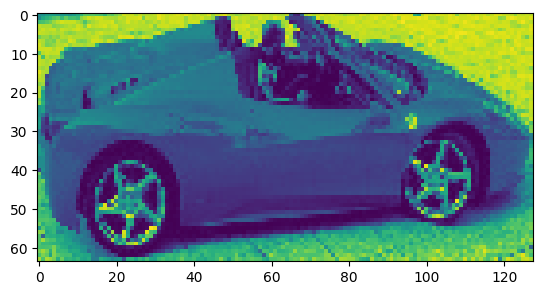

predicted_class: 159
Predicted class: 159 (Class name: 66)


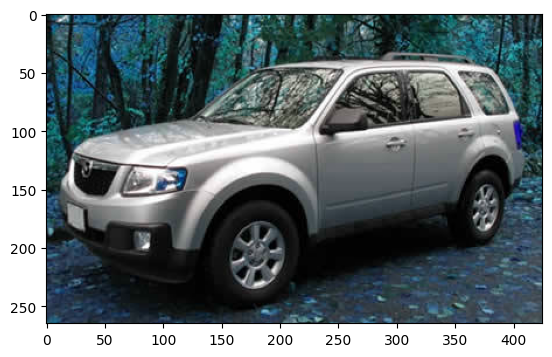

In [ ]:
def get_image(index, dataset_split = 'test'):
    row = test_csv.iloc[index]

    image_num = row['image']
    img = load_image(row['image'], dataset_split)

    x1 = row['x1']
    y1 = row['y1']
    x2 = row['x2']
    y2 = row['y2']
    img = img[y1:y2, x1:x2]

    img = cv2.resize(img, resolution)
    img = grayscale(img)

    plt.imshow(img)
    return img


# 2. Define the prediction function
def predict_image(model, image_path, device):
    # Load the image
    image = Image.open(f'../Car Kaggle Comp/test_data/{image_path}')
    plt.imshow(image)
    plt.show()
    
    # Preprocess the image
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, 1, 128, 64)
    
    # Move the image to the correct device
    image = image.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Get the model output
        outputs = model(image)
        
        # Get the predicted class (index of the max value)
        _, predicted_class = torch.max(outputs, 1)
    
    # Return the predicted class (index)
    return predicted_class.item()

#img = get_image(3, 'test')

predicted_class = predict_image(model, '00001.jpg', device)
print(f'predicted_class: {predicted_class}')
print(f"Predicted class: {predicted_class} (Class name: {full_dataset.classes[predicted_class]})")

# show a random image from the predicted class
def show_random_image(predicted_class):
    for i, row in enumerate(train_csv.iterrows()):
        if row[1]['Class'] == predicted_class:
            plt.imshow(load_image(row[1]['image']))
            break

#show_random_image(predicted_class)
#plt.show()
class_name = full_dataset.classes[predicted_class]

show_random_image(predicted_class)

In [116]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 1. Define the image preprocessing pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
    transforms.Resize((128, 64)),  # Resize image to 128x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale images
])

# 2. Create a custom dataset for the test data (since it's not in ImageFolder format)
class TestDataset(Dataset):
    def __init__(self, test_data_dir, transform=None):
        self.test_data_dir = test_data_dir
        self.transform = transform
        # Get list of all image filenames
        self.image_files = [f for f in os.listdir(test_data_dir) if os.path.isfile(os.path.join(test_data_dir, f))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image_path = os.path.join(self.test_data_dir, self.image_files[idx])
        image = Image.open(image_path)
        
        # Apply transformation (resizing, normalizing, etc.)
        if self.transform:
            image = self.transform(image)
        
        return image

# 3. Define the prediction function
def predict_image(model, image_path, device):
    # Preprocess and load the image
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
        transforms.Resize((128, 64)),  # Resize image to 128x64
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale images
    ])
    
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, 1, 128, 64)
    image = image.to(device)
    
    model.eval()  # Set the model to evaluation mode
    
    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)
    
    return predicted_class.item()

# 4. Load the test dataset and make predictions
def predict_test_data(model, test_data_dir, device):
    test_dataset = TestDataset(test_data_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    predictions = []
    model.eval()  # Set the model to evaluation mode
    
    # Loop through the test data
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, 1)
            predictions.extend(predicted_classes.cpu().numpy())
    
    return predictions

# Example usage:
test_data_dir = '../Car Kaggle Comp/test_data'
predictions = predict_test_data(model, test_data_dir, device)

# Print the predicted classes for the first 5 images
print(predictions)  # You can map these predictions to class names if needed

[175, 15, 182, 129, 77, 167, 143, 138, 149, 12, 149, 4, 178, 29, 5, 27, 136, 95, 77, 5, 88, 27, 6, 84, 167, 129, 149, 135, 147, 15, 65, 77, 15, 69, 175, 124, 142, 84, 65, 63, 63, 63, 63, 3, 188, 86, 88, 135, 168, 163, 86, 161, 124, 84, 147, 5, 159, 95, 90, 167, 129, 147, 27, 17, 167, 63, 157, 167, 180, 5, 28, 149, 28, 15, 28, 88, 88, 44, 167, 149, 60, 162, 27, 92, 167, 166, 85, 12, 113, 135, 59, 63, 65, 88, 175, 84, 147, 95, 95, 135, 5, 86, 178, 167, 159, 65, 147, 4, 189, 6, 5, 147, 7, 178, 5, 6, 15, 135, 65, 167, 5, 68, 51, 6, 85, 175, 63, 63, 124, 192, 84, 21, 135, 17, 69, 7, 168, 12, 58, 51, 27, 57, 68, 6, 149, 18, 9, 147, 53, 63, 5, 84, 27, 191, 12, 149, 88, 18, 0, 65, 60, 189, 9, 174, 188, 167, 95, 65, 175, 9, 167, 194, 167, 63, 90, 22, 178, 5, 122, 107, 147, 188, 27, 15, 178, 28, 149, 86, 15, 5, 104, 95, 76, 84, 68, 63, 18, 188, 179, 63, 63, 60, 60, 65, 15, 175, 175, 9, 27, 56, 135, 65, 58, 157, 136, 58, 0, 129, 63, 51, 159, 63, 76, 5, 167, 65, 85, 69, 146, 166, 174, 5, 147, 167,